#### Реализовать модель логистической регрессии. На базе шаблона 004-classification.ipynb необходимо реализовать операцию sigmoid в моделе логистической регрессии. В предложенном шаблоне не используется свободный член в линейной части. В качестве дополнительного упражнения, предлагается его добавить. Решение необходимо прислать в виде ipython-ноутбука с визуализацией разделяющей гиперплоскости, полученной в результате обучения.

In [1]:
#conda install -c anaconda tensorflow

In [2]:
import numpy as np
import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [4]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

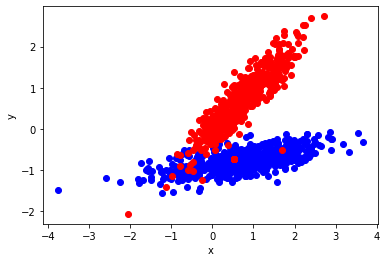

In [5]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

## Вспомогательная функция для создания операций

In [6]:
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    

    name_prefix = ''.join(np.random.choice(list(string.ascii_letters), size = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [7]:
def sigmoid_op_forward(X):
    return 1 / (1 + np.exp(-X))

def sigmoid_op_backward(op, grads):
    return op.outputs[0] * (1 - op.outputs[0]) * grads

## Создание графа вычислений и обучение модели

In [8]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения
with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_y = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 12345))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(sigmoid_op_forward,         # функция предсказания модели 
                                 [var_W],                    # аргументы функции
                                 [tf.float32],               # тип выходных значений
                                 name = 'sigmoid_op',        # имя операции 
                                 grad = sigmoid_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)         # объект графа вчислений
    
    # определяем квадратичную функцию потерь
    # результат предсказания сравнивается с правильным ответом для вычисления ошибки
    cost = tf.reduce_mean(tf.square(plh_y - var_Pred))
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(
        learning_rate = 0.3).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for epoch in range(10):
        
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_y: y[batch_indices]})
        
            # сохраняем занчения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 10 == 0:
                print('[%03d] loss=%.3f weights=%s' % (steps, loss, var_W.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
[000] loss=0.258 weights=[[0.66545296 0.23379678]]
[010] loss=0.248 weights=[[0.56592876 0.19713186]]
[020] loss=0.247 weights=[[0.47572976 0.16313964]]
[030] loss=0.263 weights=[[0.38837728 0.12488351]]
[040] loss=0.257 weights=[[0.32470113 0.10416669]]
[050] loss=0.249 weights=[[0.27383578 0.08991896]]
[060] loss=0.254 weig

## Визуализируем кривую обучения

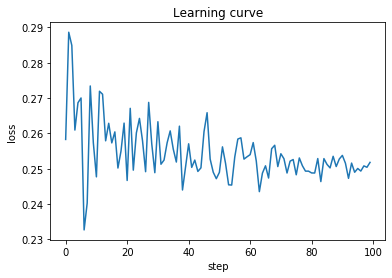

In [9]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем предсказания модели

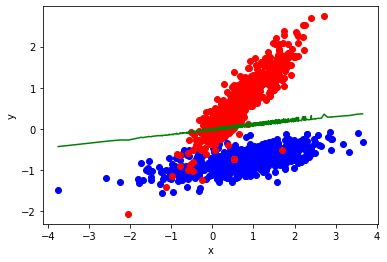

In [10]:
y_pred = np.dot(X, weights.T)  # предсказание модели

order = np.argsort(X[:, 0])
plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');